# Gamma-ray bursts prompt emission

- Dynamics:
    - Internal shock in a relativistic jet
- Emission (shock acceleration, synchrotron)

## Step 0: nonrelativistic dynamics

In [3]:
from queue import PriorityQueue
import numpy as np
import matplotlib.pyplot as plt

In [4]:
shells = []
queue = PriorityQueue()
emissions = []

class Shell:
    def __init__(self, speed, mass=1, initial_position=0, initial_time=0):
        self.speed = speed
        self.mass = mass
        self.initial_position = initial_position
        self.initial_time = initial_time
        self.alive = True
    
    def position(self, time):
        return self.initial_position + self.speed * (time - self.initial_time)
    
    def momentum(self):
        return self.mass * self.speed
    
    def kill(self):
        self.alive = False


class Event:
    def __init__(self, time):
        self.time = time
    
    def process(self, verbose=True):
        pass

    def __lt__(self, other):
        return self.time < other.time


# Production of a shell
class Production(Event):
    def __init__(self, time, speed, mass=1, initial_position=0):
        super().__init__(time)
        self.speed = speed
        self.mass = mass
        self.initial_position = initial_position
    
    def process(self, verbose=True):
        shell = Shell(self.speed, self.mass, self.initial_position, self.time)

        # find where to put this shell in the shell list
        done = False
        index = -1
        for i, s in enumerate(shells):
            if s.position(self.time) >= self.initial_position:
                shells.insert(i, shell)
                index = i
                done = True
                break
        if not done:
            index = len(shells)
            shells.append(shell)

        # compute new possible collisions with adjacent shells
        if  0 <= index-1:
            anterior = shells[index-1]
            predict_collision(self.time, anterior, shell)
        if index+1 < len(shells):
            posterior = shells[index+1]
            predict_collision(self.time, shell, posterior)


def predict_collision(now, s1, s2):
    if s1.speed > s2.speed:
        deltax = s2.position(now) - s1.position(now)
        deltav = s1.speed - s2.speed
        collision_time = now + deltax / deltav

        queue.put(Collision(collision_time, s1, s2))


# Collision of two shells
class Collision(Event):
    def __init__(self, time, s1, s2):
        super().__init__(time)
        self.s1 = s1
        self.s2 = s2

    def process(self, verbose=True):
        s1, s2 = self.s1, self.s2

        # check if shells are still alive
        if not s1.alive or not s2.alive:
            return

        # check that positions are indeed equal
        tol = 1e-8
        assert abs(s1.position(self.time) - s2.position(self.time)) < tol
        
        # remove shells from list and kill them
        shells.remove(s1)
        shells.remove(s2)
        s1.kill()
        s2.kill()

        # compute parameters of new shell
        mass = s1.mass + s2.mass
        speed = (s1.mass * s1.speed + s2.mass * s2.speed) / mass
        position = s1.position(self.time)

        if verbose:
            print(f"mass={mass}, speed={speed}, position={position}")

        # produce new shell
        e = Production(self.time, speed, mass, position)
        e.process()

        # compute emitted energy
        energy_before = (s1.mass * s1.speed**2 + s2.mass * s2.speed**2)/2
        energy_after = mass * speed**2 / 2
        emitted_energy = energy_before - energy_after
        emissions.append((self.time, emitted_energy))

In [5]:
def speed_profile1(t):
    return t

def speed_profile2(t):
    return 2 / np.pi * np.arctan(8*t-4)+1

@np.vectorize
def speed_profile3(t):
    if t < 0.5: return 0
    return 1

In [6]:
# Initialize parameters

shells = []
queue = PriorityQueue()
emissions = []

speed_profile = speed_profile2

maxtime = 5
for time in np.linspace(0, maxtime, 5001):
    speed = speed_profile(time/maxtime)
    e = Production(time, speed)
    queue.put(e)


In [7]:
# Perform simulation
while not queue.empty():
    event = queue.get()
    #print(f"t={event.time}")
    event.process(verbose=False)

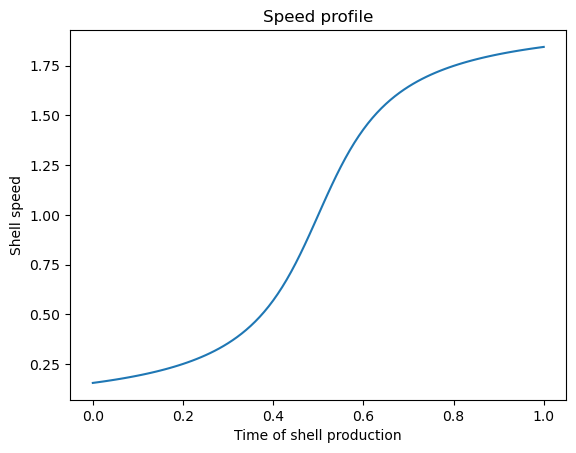

In [8]:
t = np.linspace(0,1,101)
plt.plot(t, speed_profile(t))
plt.title("Speed profile")
plt.xlabel("Time of shell production")
plt.ylabel("Shell speed")
plt.show()

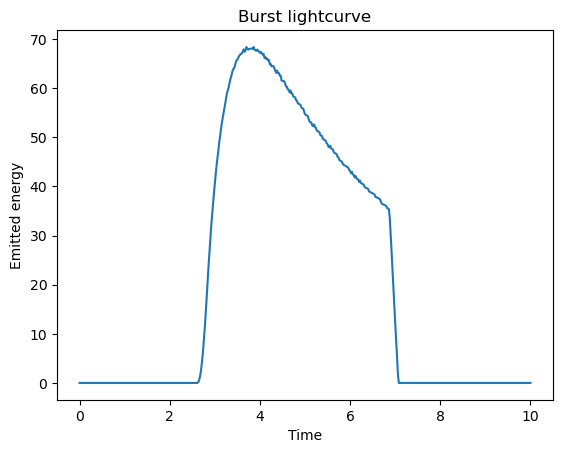

In [20]:
t = np.linspace(0,10,501)

@np.vectorize
def emission_profile1(t):
    if 0 <= t and t < 0.2:
        return 1
    return 0

emission_profile = emission_profile1

burst = sum([energy*emission_profile(t-t0) for t0,energy in emissions])

plt.plot(t, burst)
plt.title("Burst lightcurve")
plt.xlabel("Time")
plt.ylabel("Emitted energy")
plt.show()

## Step 1: dynamics

## Step 2: properties of shocked matter

## Synchrotron emission

## Signal measured by the observer

## Discussion